In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import re
import logging
import time
import polars as pl

#setup
logging.basicConfig(level=logging.INFO)

#group library
from label_legends.preprocess import holdout, transform, load_data
from label_legends.preprocess import holdout, transform, load_data, load_test
from label_legends.result import calculate_scores, download_predictions, get_experiment, load_predictions, client, get_current
import json
import mlflow


c:\Users\noika\Documents\NLP project\label_legends\nlp-ie-label-legends\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def evaluate_baseline(true_labels, predictions, baseline_name):
    
    logging.info(f"Evaluating {baseline_name}...")
    
    #precision, recall, F1(macro avg)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")
    
    #confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Print Evaluation Metrics
    print(f"\n{baseline_name} Evaluation Metrics:")
    print(f"Precision (Macro Avg): {precision:.4f}")
    print(f"Recall (Macro Avg): {recall:.4f}")
    print(f"F1 Score (Macro Avg): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

In [4]:
#loading the data
logging.info("Loading data...")
load_data().collect()

#transforming the data
val, tra = holdout()
logging.info("Transforming data...")
tra = transform(tra)
val = transform(val)

#loading the test set
logging.info("Loading the test set...")
test = transform(load_test().collect())

#converting 'label' column to integer
logging.info("Converting labels to integers...")
tra = tra.with_columns(
    pl.col("label").cast(pl.Int32)
)
val = val.with_columns(
    pl.col("label").cast(pl.Int32)
)

INFO:root:Loading data...
INFO:root:Transforming data...
c:\Users\noika\Documents\NLP project\label_legends\nlp-ie-label-legends\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
INFO:root:Loading the test set...
INFO:root:Converting labels to integers...


In [5]:
tra

id,text,tokens,token_ids,label
i64,str,list[str],list[i64],i32
26016,"""#VoteDemOut seditionist wanna …","[""#"", ""votedemout"", … ""ven""]","[7, 3000, … 3000]",0
41060,"""Cerno hops from wave to wave: …","[""cerno"", ""hop"", … "".""]","[3000, 3000, … 26]",1
35766,"""think about it.. he´s called J…","[""think"", "".."", … ""elect""]","[2688, 27, … 911]",0
23678,"""Hmm, you could rewrite this wi…","[""hmm"", "","", … ""justsaying""]","[1284, 22, … 3000]",0
52396,"""Every girl in a game, or on si…","[""girl"", ""game"", … "".""]","[1164, 1135, … 26]",0
…,…,…,…,…
6785,"""I just think my dick couldn't …","[""just"", ""think"", … ""..😂😂😂""]","[1482, 2688, … 3000]",0
31355,"""no he deadasss hit the nail on…","[""deadass"", ""hit"", … "".""]","[3000, 1282, … 26]",0
49834,"""Aren't these goblins always wh…","[""goblins"", ""whine"", … ""hastagsarestillcool""]","[3000, 2914, … 3000]",0


In [6]:
#putting the text and label columns into lists
train_texts = tra['text'].to_list()
train_labels = tra['label'].to_list()

val_texts = val['text'].to_list()
val_labels = val['label'].to_list()

test_texts = test['text'].to_list()
test_labels = test['label'].to_list()

In [7]:
#calculating the most frequent class
logging.info("Calculating most frequent class...")
mf_class = max(set(val_labels), key=val_labels.count)

INFO:root:Calculating most frequent class...


In [8]:
#predict the most frequent class

#timing the test time
start_time = time.time()

#redict and evaluate
logging.info(f"Most frequent class: {mf_class}")
test_pred_mf = [mf_class] * len(test_labels)

train_time_mf = 0  # No training time for most frequent baseline
test_time_mf = time.time() - start_time

INFO:root:Most frequent class: 0


In [13]:
#evaluation
evaluate_baseline(test_labels, test_pred_mf, "Most Frequent Baseline")
print(f"Training Time: {train_time_mf:.4f} seconds")
print(f"Test Time: {test_time_mf:.4f} seconds")

INFO:root:Evaluating Most Frequent Baseline...



Most Frequent Baseline Evaluation Metrics:
Precision (Macro Avg): 0.0000
Recall (Macro Avg): 0.0000
F1 Score (Macro Avg): 0.0000

Confusion Matrix:
[[8885    0]
 [3115    0]]
Training Time: 0.0000 seconds
Test Time: 0.0000 seconds


c:\Users\noika\Documents\NLP project\label_legends\nlp-ie-label-legends\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


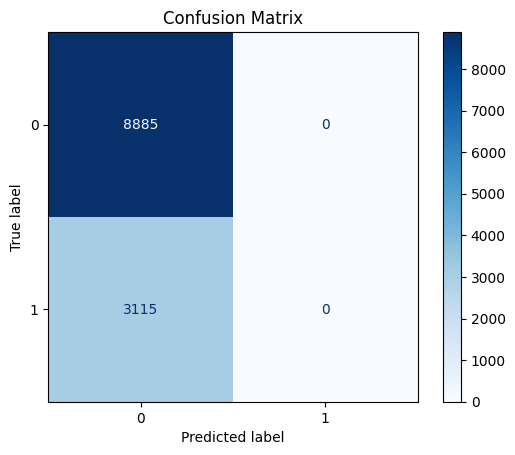

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_labels, test_pred_mf)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [11]:
scores_mf = calculate_scores(test_labels, test_pred_mf)
print(scores_mf)

precision:	0.0000
recall:		0.0000
fscore:		0.0000
accuracy:	0.7404
tn: 8885	 fp: 0
fn: 3115	 tp: 0


c:\Users\noika\Documents\NLP project\label_legends\nlp-ie-label-legends\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="most frequent testing"
        ):
    mlflow.log_params({"most_frequent_class": mf_class})
    mlflow.log_metrics(scores_mf.asdict())
    mlflow.set_tag("model", "most frequent")

    mlflow.log_table({"id": test["id"], "prediction": test_pred_mf}, "predictions_mf.json")

    #log the model
    prediction_data = {
        "columns": ["id", "prediction"],
        "data": [[id_, pred] for id_, pred in zip(test["id"], test_pred_mf)]
    }
    # Save to a JSON file
    predictions_file = r"..\\resource\\mlflow\\mostfrequent\\predictions.json"
    with open(predictions_file, "w") as f:
        json.dump(prediction_data, f, indent=4)
        
    # Log the JSON file as an artifact
    mlflow.log_artifact(predictions_file)
        
    # Simulate model registration
    mlflow.set_tag("registered_model_name", "mostfrequent")
    mlflow.set_tag("model_alias", "current")

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/mf_predictions.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="mostfrequent") 


client().set_registered_model_alias("mostfrequent", "current", registered_model.version)

Successfully registered model 'mostfrequent'.
Created version '1' of model 'mostfrequent'.


In [16]:
get_current("mostfrequent")

<ModelVersion: aliases=['current'], creation_timestamp=1734030429563, current_stage='None', description=None, last_updated_timestamp=1734030429563, name='mostfrequent', run_id='2629ed6b6f424ece95a3565a2c820454', run_link=None, source='file:///c:/Users/noika/Documents/NLP%20project/label_legends/nlp-ie-label-legends/notebooks/mlruns/293497917933323667/2629ed6b6f424ece95a3565a2c820454/artifacts/mf_predictions.json', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [17]:
load_predictions("mostfrequent").head()

id,prediction
i64,i64
100,0
10005,0
10006,0
10007,0
10008,0
